In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas as pd
#from pomegranate import BayesianNetwork

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [4]:
def sample_latent(how_many, latents_sizes, correlated=False, 
                    in_idx=None, out_idx=None, map_fn=None):
    
    samples = np.zeros((how_many, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=how_many)

    if correlated:
        samples[:, out_idx] = map_fn(samples[:,in_idx[0]], samples[:,in_idx[1]], samples[:,in_idx[2]])
    
    return samples

def length_map_fn(posX, posY, shape):

    def get_length(posX, posY, shape):
        
        # horizontal
        if shape == 0:
            if (posX, posY) == (0,0) or (posX, posY) == (1,0) or (posX, posY) == (2,0):
                return 2
            if (posX, posY) == (0,1) or (posX, posY) == (1,1) or (posX, posY) == (2,1):
                return 1
            if (posX, posY) == (0,2) or (posX, posY) == (1,2) or (posX, posY) == (2,2):
                return 0
        
        # Transpose of above - vertical
        if shape == 1:
            if (posX, posY) == (0,0) or (posX, posY) == (0,1) or (posX, posY) == (0,2):
                return 2
            if (posX, posY) == (1,0) or (posX, posY) == (1,1) or (posX, posY) == (1,2):
                return 1
            if (posX, posY) == (2,0) or (posX, posY) == (2,1) or (posX, posY) == (2,2):
                return 0
        #print(posX, posY, shape)
        raise NotImplementedError
    
    return np.vectorize(get_length)(posX, posY, shape)
    
def get_observation_from_latent(latent, correlated=True):

    X = np.zeros(shape=(3,3))

    latent = latent.astype(int)
    posX, posY, shape, length = latent[0], latent[1], latent[2], latent[3]

    if correlated:
        # horizontal bar
        if shape == 0:
            for i in range(length + 1):
                X[posX, posY + i] = 1.0

        # vertical bar    
        if shape == 1:
            for i in range(length + 1):
                X[posX + i, posY] = 1.0
    else:
        # horizontal bar
        if shape == 0:
            X[posX, :] = 1.0

        # vertical bar    
        if shape == 1:
            X[:, posY] = 1.0

    return X

def get_observation_from_latent_uncorr(latent):

    X = np.zeros(shape=(3,3))

    latent = latent.astype(int)
    posX, posY, shape, length = latent[0], latent[1], latent[2], latent[3]

    # horizontal bar
    if shape == 0:
        for i in range(length + 1):
            X[posX, posY + i] = 1.0

    # vertical bar    
    if shape == 1:
        for i in range(length + 1):
            X[posX + i, posY] = 1.0

    return X


def show_density(imgs):
    _, ax = plt.subplots()
    mean_image = imgs.mean(axis=0)
    ax.imshow(mean_image, interpolation='nearest', cmap='Greys_r')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])
    return mean_image

In [5]:
# Create some data
metadata = {
    'latents_possible_values': {
        'posX': [0, 1, 2],
        'posY': [0, 1, 2],
        'shape': [0, 1],
        'length': [0 , 1, 2]
    },
    'latents_sizes': np.array([3, 3, 2 ,3]),
    'latents_names': ['posX', 'posY', 'shape', 'length']
}

# sample some images 
N = 100000
imgs = np.zeros(shape=(N, 3, 3))
latents = np.zeros(shape=(N, 4)) 
for i in range(N):
    latents[i] = sample_latent(1, metadata['latents_sizes'], correlated=False)[0]
    imgs[i] = get_observation_from_latent(latents[i], correlated=False)


npz_data = dict()
npz_data['images'] = imgs
npz_data['latents_values'] = latents
npz_data['metadata'] = metadata


[1. 1. 0. 0.]
[1. 0. 1. 2.]
[0. 1. 0. 1.]
[2. 1. 0. 0.]
[0. 2. 1. 1.]
[1. 1. 1. 1.]
[2. 0. 1. 0.]
[1. 0. 0. 1.]


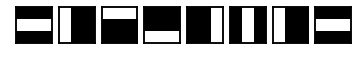

In [8]:
# show some images

fig, ax = plt.subplots(1, 8)
for i in range(8):
    idx = np.random.choice(N)
    print(latents[idx])
    ax[i].imshow(imgs[idx], cmap='Greys_r')
    ax[i].grid('off')
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

[[0.3324  0.33522 0.33356]
 [0.33221 0.33503 0.33337]
 [0.33141 0.33423 0.33257]]


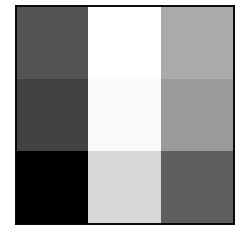

In [10]:
m = show_density(imgs)
print(m)

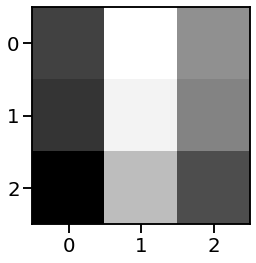

In [12]:
plt.imshow(m,cmap='gray')

In [23]:
pd_latents = pd.DataFrame(latents, columns=['posX', 'posY', 'shape', 'length'])
pd_latents.head()

,posX,posY,shape,length
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,2.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0
4,2.0,0.0,0.0,2.0


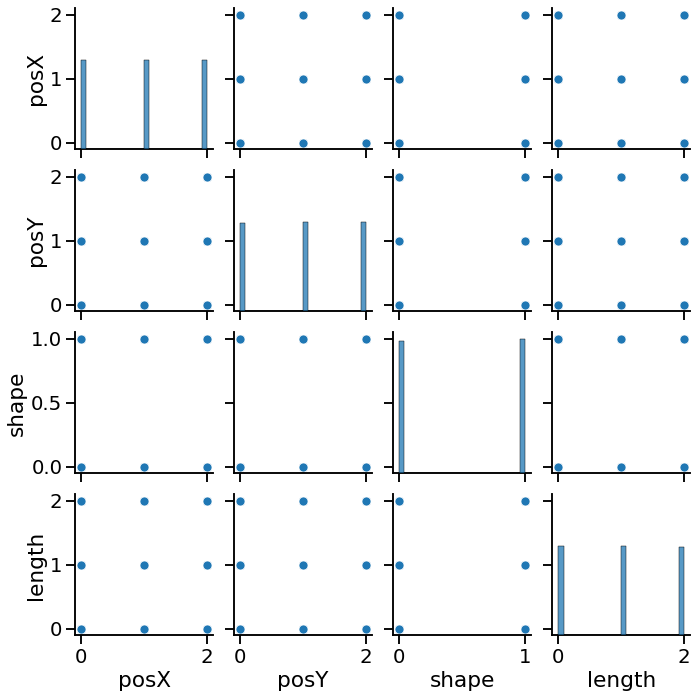

In [24]:
sns.pairplot(pd_latents)

In [28]:
model = BayesianNetwork.from_samples(latents, 
                                     state_names=['posX', 'posY', 'shape', 'length'], 
                                     algorithm='exact')
print(model.structure)

((), (2, 3), (), (0, 2))


In [13]:
np.savez_compressed("../datasets/toydata/toydata_3x3_uc.npz",
    images= imgs,
    latents_values=latents,
    metadata= metadata
)